# Implementation of ResNet-50 Model

In [61]:
import os
import sys
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [62]:
# Global Vars
path = '../../Datasets/ImageNet-Sketch/sketch'
class_paths = [f for f in Path(path).glob('*')]
image_paths = [f for f in Path(path).glob('*\*.JPEG')]
num_classes = len(class_paths)
dataset_total_size = len(image_paths)
image_size = 224

print(os.getcwd())


c:\Users\Admin\Desktop\Tharja\Term 7\CV\50.039-CV-Project\Models\ResNet-50


In [63]:
print(f'# Classes: {num_classes}')
print(f'# Images: {dataset_total_size}')
print(class_paths[:10])

# Classes: 1000
# Images: 50889
[WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01440764'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01443537'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01484850'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01491361'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01494475'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01496331'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01498041'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01514668'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01514859'), WindowsPath('../../Datasets/ImageNet-Sketch/sketch/n01518878')]


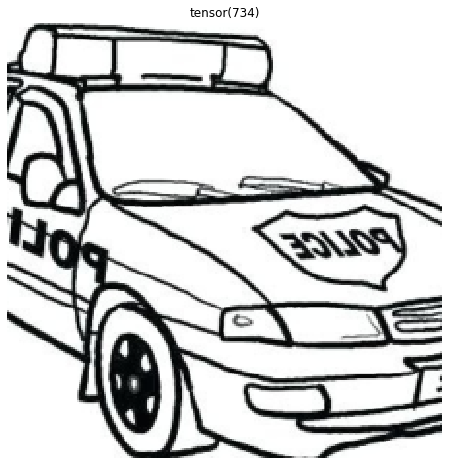

In [69]:
# Test loading in the data
idx = random.randint(0, 999)
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

sample = datasets.ImageFolder(path, transform=transform)
sample_dataloader = DataLoader(sample, batch_size=32, shuffle=True)

img, labels = next(iter(sample_dataloader))

image = img[0].swapaxes(0,1)
image = image.swapaxes(1,2)
plt.imshow(image)
plt.title(labels[0])
plt.axis('off')
plt.show()

In [ ]:
# Dataset Class
class CreateDataset(Dataset):
    


In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

Using cache found in C:\Users\Admin/.cache\torch\hub\pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
n_epochs = 1
batch_size = 128

for epoch in range(n_epochs):

    permutation = torch.randperm(X.size()[0])

    for i in range(0,X.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X[indices], Y[indices]

        # in case you wanted a semi-full example
        outputs = model.forward(batch_x)
        loss = lossfunction(outputs,batch_y)

        loss.backward()
        optimizer.step()